# Knee Joint Replacement Prediction Regression Model

I recently finished an in-depth data exploration on the regional healthcare costs in New York State where I singled out knee joint replacement surgeries as one the most common medical procedures performed, and one of the most expensive (costs can vary by more than $100,000). 

Despite only a moderate increase in patient volumes (11,000 new patients treated in 2016 compared to 2009) their costs have skyrocketed over time. In an effort to help New York State residents financially plan for this medical procedure, I decided to build a machine learning model that could predict the cost of a knee joint replacement surgery. My goal was to have this model complement other healthcare cost estimators available to give patients more financial information. I framed this problem as a supervised regression task using a single batch of data.

## 2. Get the Data

In [1]:
#Import the necessary libraries to perform exploratory data analysis

import pandas as pd #Import Pandas
import numpy as np #Import Numpy

import matplotlib.pyplot as plt

The data was obtained from the NYS Department of Health [website.](https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/gnzp-ekau) This data is 2016 Hospital Inpatient Discharges (SPARCS de-identified). It contains basic record level detail for individual discharges. 

From my previous __[analysis](https://towardsdatascience.com/data-analysis-of-new-york-state-regional-healthcare-costs-d72fb579601f)__, knee joint replacement surgery was one of the most interesting medical conditions. Let's build a model to predict its charge. 

In [2]:
#Read the .csv file
df_original = pd.read_csv('..\Knee Joint Replacement\Hospital_Inpatient_Discharges_SPARCS_DeIdentified_2016_KneeReplacement_Only.csv')

#Make a copy and work through the copy.
df = df_original.copy()

#Get an initial impression of the dataframe.
df.head()

C:\Users\Manuel Ramirez\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,...,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,Ratio of Total Costs to Total Charges
0,35,Western NY,Allegany,228000.0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,50 to 69,148,M,White,...,Self-Pay,213053.0,213053.0,NaN,0,N,N,23344.75,11281.89,0.483273
1,36,Western NY,Allegany,228000.0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,50 to 69,148,F,White,...,Self-Pay,213053.0,213053.0,NaN,0,N,N,25154.00,12415.67,0.493586
2,101,Western NY,Allegany,228000.0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,50 to 69,148,F,White,...,Self-Pay,213053.0,213053.0,NaN,0,N,N,29389.50,14873.56,0.506084
3,103,Western NY,Allegany,228000.0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,50 to 69,148,M,White,...,Private Health Insurance,213053.0,213053.0,NaN,0,N,N,25029.50,12402.49,0.495515
4,106,Western NY,Allegany,228000.0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...,70 or Older,148,F,White,...,Self-Pay,213053.0,213053.0,NaN,0,N,N,28976.00,14547.43,0.502051


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39824 entries, 0 to 39823
Data columns (total 39 columns):
Unnamed: 0                               39824 non-null int64
Health Service Area                      39824 non-null object
Hospital County                          39824 non-null object
Operating Certificate Number             39824 non-null float64
Facility Id                              39824 non-null float64
Facility Name                            39824 non-null object
Age Group                                39824 non-null object
Zip Code - 3 digits                      39806 non-null object
Gender                                   39824 non-null object
Race                                     39824 non-null object
Ethnicity                                39824 non-null object
Length of Stay                           39824 non-null object
Type of Admission                        39824 non-null object
Patient Disposition                      39824 non-null object
Discharg

In [4]:
#There are 2,343,429 instances, and not all of them will be for knee joint replacement surgery.
#Drop all of these rows from the dataframe.
df = df.drop(labels=df.loc[df.loc[:,'APR DRG Description'] != 'Knee joint replacement'].index,axis=0)

In [6]:
#There are now 39,824 instances and they are now all related to knee joint replacement surgery. 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39824 entries, 35 to 2342066
Data columns (total 38 columns):
Health Service Area                      39824 non-null object
Hospital County                          39824 non-null object
Operating Certificate Number             39824 non-null float64
Facility Id                              39824 non-null float64
Facility Name                            39824 non-null object
Age Group                                39824 non-null object
Zip Code - 3 digits                      39806 non-null object
Gender                                   39824 non-null object
Race                                     39824 non-null object
Ethnicity                                39824 non-null object
Length of Stay                           39824 non-null object
Type of Admission                        39824 non-null object
Patient Disposition                      39824 non-null object
Discharge Year                           39824 non-null int64
CCS D

In [7]:
#Let's work through the columns, identify those we can eliminate, and drop them. We want to eliminate redundant information or
#information a patient may not know on their own.

df.columns.tolist() #Output below

#Comment those columns we want to keep.
col2drop = ['Health Service Area', #This is their designation for hospital region. Drop it since we'll use our own. Drop. 
            #'Hospital County',                                                              #Data Type: Nominal
            'Operating Certificate Number', #We do not need the operating certificate number of the facility. Drop. 
            #'Facility Id',                                                                  #Data Type: Nominal
            #'Facility Name',                                                                #Data Type: Nominal
            #'Age Group',                                                                    #Data Type: Ordinal
            'Zip Code - 3 digits', #We won't incorporate socioeconomic status of the patient. Drop.
            #'Gender',                                                                       #Data Type: Nominal
            #'Race',                                                                         #Data Type: Nominal
            #'Ethnicity',                                                                    #Data Type: Nominal
            #'Length of Stay',                                                               #Data Type: Ordinal
            #'Type of Admission',                                                            #Data Type: Nominal
            #'Patient Disposition',                                                          #Data Type: Nominal
            'Discharge Year', #We know the discharge year is 2016. Drop. 
            'CCS Diagnosis Code', #Additional information not needed since we are basing codes on APR DRG. Drop. 
            'CCS Diagnosis Description', #Same as above. Drop. 
            'CCS Procedure Code', #Additional information not needed since we are basing codes on APR DRG. Drop. 
            'CCS Procedure Description', #Same as above. Drop. 
            'APR DRG Code', #We've already filtered out the other conditions so we don't need this anymore. Drop. 
            'APR DRG Description', #Same as above. Drop. 
            'APR MDC Code', #Additional information not needed. We know knee joint replacement is related to musculoskeletal. Drop.
            'APR MDC Description', #Same as above. Drop. 
            #'APR Severity of Illness Code',                                                 #Data Type: Ordinal
            #'APR Severity of Illness Description',                                          #Data Type: Ordinal
            #'APR Risk of Mortality',                                                        #Data Type: Ordinal
            'APR Medical Surgical Description', #Joint knee replacement is a surgical procedure. This is already known. Drop.
            #'Payment Typology 1',                                                           #Data Type: Nominal
            #'Payment Typology 2',                                                           #Data Type: Nominal
            #'Payment Typology 3',                                                           #Data Type: Nominal
            'Attending Provider License Number', #Patients would not realistically know this level of information. Drop. 
            'Operating Provider License Number', #Patients would not realistically know this level of information. Drop. 
            'Other Provider License Number', #Patients would not realistically know this level of information. Drop. 
            'Birth Weight', #Relevant only to newborns. Drop. 
            'Abortion Edit Indicator', #Relevant only for abortion medical procedures. Drop. 
            #'Emergency Department Indicator',                                               #Data Type: Binary
            #'Total Charges',                                                                #Data Type: Continuous
            #'Total Costs',                                                                  #Data Type: Continuous
            #'Ratio of Total Costs to Total Charges'                                         #Data Type: Continuous
             ]
df = df.drop(labels=col2drop,axis=1).reset_index(drop=True)

## 3. Discover, explore and visualize the data to gain insights

In [8]:
def dataexplore_pie(df,column_label):
    
    random_i = np.random.permutation(len(df.loc[:,column_label].value_counts()))
    
    category_labels = df.loc[:,column_label].value_counts()[random_i].index
    values = df.loc[:,column_label].value_counts()[random_i]
    values_perc = values / values.sum() * 100
    
    wedgeprops = {'linewidth':1.5,'edgecolor':'black'}
    textprops = {'fontsize':13,'fontstyle':'italic'}

    annotated_labels = [category_labels.tolist()[i] + ', ' + str(values_perc[i].round(2)) + '%' \
                        for i in range(0,len(category_labels))]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)  
    ax.pie(values_perc,wedgeprops=wedgeprops,labels=annotated_labels,textprops=textprops)
    
    plt.show()

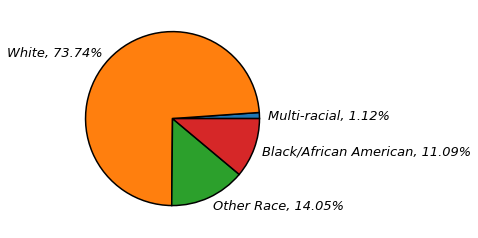

In [9]:
dataexplore_pie(df,'Race')

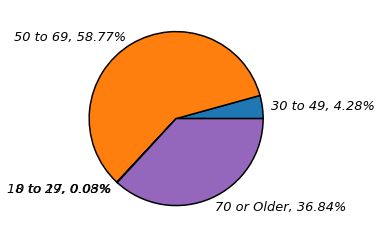

In [10]:
dataexplore_pie(df,'Age Group')

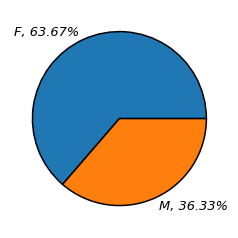

In [11]:
dataexplore_pie(df,'Gender')

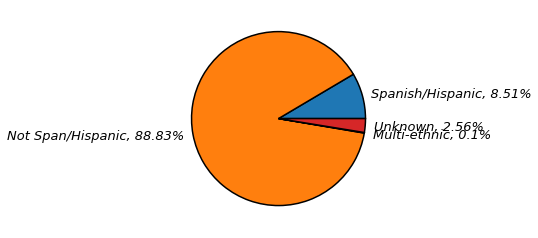

In [12]:
dataexplore_pie(df,'Ethnicity')

## 4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.

__Go through column by column modifying it to better fit the underlying data patterns in ML algorithms.__

In [13]:
#Let's go through each column in order. We'll skip Hospital County since it will be used for feature engineering at the end.
df.columns.tolist()

['Hospital County',
 'Facility Id',
 'Facility Name',
 'Age Group',
 'Gender',
 'Race',
 'Ethnicity',
 'Length of Stay',
 'Type of Admission',
 'Patient Disposition',
 'APR Severity of Illness Code',
 'APR Severity of Illness Description',
 'APR Risk of Mortality',
 'Payment Typology 1',
 'Payment Typology 2',
 'Payment Typology 3',
 'Emergency Department Indicator',
 'Total Charges',
 'Total Costs',
 'Ratio of Total Costs to Total Charges']

__Facility Id and Facility Name__

Facility Id and Facility name both refer to the same information. I'll keep Facility Id since it is easier to work with than a string of names. The Id tag to the facility poses an interesting challenge. It would certainly be one of the input features a patient would know. However, because this feature has high cardinality, encoding it is a challenge. OneHotEncoding would generate too many columns and we'd end up with the curse of dimensionality. Instead, I'll incorporate the lattitude/longitude information for each hospital. In my previous __[blog post](https://towardsdatascience.com/data-analysis-of-new-york-state-regional-healthcare-costs-d72fb579601f)__ I used the General Healthcare Facility to obtain this information. I will use it again here.

In [14]:
#Facility Id and Facility name both refer to the same information. I'll keep Facility Id since it is easier to work with.
#First, I'll create a new dataframe that maps the two together. 
df_hosp_id = df.loc[:,['Facility Id','Facility Name']].drop_duplicates(keep='first')
df_hosp_id.head()

,Facility Id,Facility Name
0,39.0,Memorial Hosp of Wm F & Gertrude F Jones A/K/A...
24,66.0,Olean General Hospital
103,98.0,Brooks Memorial Hospital
277,103.0,Woman's Christian Association
288,114.0,TLC Health Network Lake Shore Hospital


__Facility Id.__

In [17]:
#Read health facility general information dataset
df_healthfacility = pd.read_csv('..\Knee Joint Replacement\Health_Facility_General_Information.csv',usecols=['Facility ID','Facility Latitude','Facility Longitude'])

In [18]:
#Merge the general health facility dataframe based on facility ids.
df = df.merge(df_healthfacility,
              how='left',
              left_on='Facility Id',
              right_on='Facility ID')
df = df.drop(columns='Facility ID')

In [19]:
#Double check to see all facilities have their corresponding lattitude and longitude information.
df.loc[df.loc[:,'Facility Latitude'].isna(),'Facility Id'].unique() 

#2 Facilities did not. 

array([ 776., 3376.])

In [20]:
#What are their names?
df.loc[df.loc[:,'Facility Latitude'].isna(),'Facility Name'].unique()

array(['Nyack Hospital',
       "Long Island Jewish Schneiders Children's Hospital Division"],
      dtype=object)

In [21]:
#Add the lattitude/longitude information for each. I used Google Maps to find the facility by its name and got its geotags.
df.loc[df.loc[:,'Facility Name'] == 'Nyack Hospital','Facility Latitude'] = 41.097133
df.loc[df.loc[:,'Facility Name'] == 'Nyack Hospital','Facility Longitude'] = -73.926049

df.loc[df.loc[:,'Facility Name'] == "Long Island Jewish Schneiders Children's Hospital Division",'Facility Latitude'] = 40.753661
df.loc[df.loc[:,'Facility Name'] == "Long Island Jewish Schneiders Children's Hospital Division",'Facility Longitude'] = -73.707514

In [22]:
#I also made sure to add the missing geotags back into the general health facility dataframe for reference.
missing_geotags = {'Facility ID':[776,3376],
                   'Facility Latitude':[41.097133,-73.926049],
                   'Facility Longitude':[40.753661,-73.707514]}
df_healthfacility = df_healthfacility.append(pd.DataFrame.from_dict(missing_geotags),sort=False,ignore_index=True)

In [23]:
#Double check to see all facilities have their corresponding lattitude and longitude information. 
df.loc[df.loc[:,'Facility Latitude'].isna(),'Facility Name'].unique() 

#No missing information is present.

array([], dtype=object)

_We'll keep the facility Id and facility name until we are finished encoding/feature engineering. Then we will drop them._

__Age Group__

In [24]:
#What are the age group labels?
age_group_labels = (df.loc[:,'Age Group']).astype('category').cat.categories.tolist()
age_group_labels

#This feature can be replaced with a label encoder. It is also ordinal.  

['0 to 17', '18 to 29', '30 to 49', '50 to 69', '70 or Older']

In [25]:
#Replace the age groups with a numerical encoding.
replace_age_group = {'Age Group': {k: v for k,v in zip(age_group_labels,list(range(1,len(age_group_labels)+1)))}}
df = df.replace(replace_age_group)

__Gender__

In [26]:
#What are the Gender labels?
(df.loc[:,'Gender']).unique().tolist()

#This feature can be replaced with a label encoder. It is binary.

['M', 'F']

In [27]:
#Replace the gender with a binary numerical encoding.
gender_labels = (df.loc[:,'Gender']).unique().tolist()
replace_gender = {'Gender':{'M':0,'F':1}}
df = df.replace(replace_gender)

__Length of Stay__

In [28]:
#What are the values for length of stay?
df['Length of Stay'].unique()

array(['3', '4', '6', '13', '5', '11', '8', '2', '1', '15', '7', '20',
       '10', '9', '14', '49', '37', '16', '23', '12', '22', '44', '21', 6,
       1, 2, 5, 4, 3, 7, 8, 44, 42, 15, 9, '17', '18', 11, 13, '47', '25',
       19, '35', '19', '36', 20, 14, 10, '70', '71', '59', '120 +', '31',
       '43', '102', '58', '55', '30', '78', '48', '24', '29', '38', '42',
       '34', 17, 18, 27, '27'], dtype=object)

_Intuitively, you would assume that all the values are integers. However, there is a label for patients who stay longer than 120 days (labeled as '120 +'). Since we do not know exactly how many days above 120 the patients stayed for, I will simply change this value to 120._ 

In [29]:
df.loc[df.loc[:,'Length of Stay'] == '120 +','Length of Stay'] = 120
df['Length of Stay'] = df['Length of Stay'].astype(dtype='uint8')

__Type of Admission.__

In [30]:
#What are the values for type of admission?
df.loc[:,'Type of Admission'].value_counts() / df.loc[:,'Type of Admission'].value_counts().sum() * 100

Elective         96.411712
Emergency         1.908397
Urgent            1.624648
Newborn           0.035155
Not Available     0.012555
Trauma            0.007533
Name: Type of Admission, dtype: float64

_As expected, knee joint replacement surgery is an elective surgery. However, between 1% - 2% of patients are labelled as emergency or urgent. The other categories are negligible. Let's combine newborn, not available and trauma as 'Other Admission Type'_

In [31]:
top_admission_type = df.loc[:,'Type of Admission'].value_counts().index[0:4].tolist()
bool_admission_type = df.loc[:,'Type of Admission'].isin(top_admission_type)
df.loc[~bool_admission_type,'Type of Admission'] = 'Other Admission Type'

__Patient Disposition.__

In [32]:
df.loc[:,'Patient Disposition'].unique().size

19

In [33]:
df.loc[:,'Patient Disposition'].value_counts() / df.loc[:,'Patient Disposition'].value_counts().sum() * 100

Home w/ Home Health Services             45.025613
Skilled Nursing Home                     26.705002
Home or Self Care                        20.439936
Inpatient Rehabilitation Facility         6.842607
Short-term Hospital                       0.399257
Hosp Basd Medicare Approved Swing Bed     0.135597
Another Type Not Listed                   0.123041
Cancer Center or Children's Hospital      0.072820
Court/Law Enforcement                     0.050221
Hospice - Home                            0.047710
Expired                                   0.042688
Facility w/ Custodial/Supportive Care     0.030133
Left Against Medical Advice               0.027622
Medicaid Cert Nursing Facility            0.017577
Hospice - Medical Facility                0.017577
Medicare Cert Long Term Care Hospital     0.007533
Psychiatric Hospital or Unit of Hosp      0.007533
Federal Health Care Facility              0.005022
Critical Access Hospital                  0.002511
Name: Patient Disposition, dtyp

_Patient dispostion related to what happened to the patient after they left the hospital. 99% of patients fell into 4 categories. They either went home with home health services, went into a skilled nursing home, went home without a home health service (self care) or went into an inpatient rehab facility. Again, let's combine all the other cateogires and label them as 'Other Disposition'._

In [34]:
#Replace all 15 categories as 'Other'
top_patient_disp = df.loc[:,'Patient Disposition'].value_counts().index[0:4].tolist()
bool_patient_disp = df.loc[:,'Patient Disposition'].isin(top_patient_disp)
df.loc[~bool_patient_disp,'Patient Disposition'] = 'Other Disposition'

__Severity of Illness__

In [35]:
#Severity of Illness is self explanatory. Let's create a mapping for it and use the code values (since they are inherently
#numerical) as a label encoder within our dataframe.
df_SOI_id = df.loc[:,['APR Severity of Illness Code','APR Severity of Illness Description']].drop_duplicates(keep='first')
df_SOI_id

,APR Severity of Illness Code,APR Severity of Illness Description
0,1,Minor
3,2,Moderate
5,4,Extreme
6,3,Major


In [36]:
df = df.drop(labels=['APR Severity of Illness Description'],axis=1).reset_index(drop=True)

__Risk of Mortality.__

In [37]:
#Risk of Mortality is also self explanatory. In this dataframe however it is explained with strings. Let's replace them with
#numerical values instead. 
APR_risk_mort_dict = {'Minor':1,'Moderate':2,'Extreme':3,'Major':4}
df.loc[:,'APR Risk of Mortality'] = df.loc[:,'APR Risk of Mortality'].map(APR_risk_mort_dict)

__Payment Typology.__

There are 3 columns for payment typology. They refer to how the patient paid for the procedure. 

In [38]:
df.loc[:,['Payment Typology 1','Payment Typology 2','Payment Typology 3']].head()

,Payment Typology 1,Payment Typology 2,Payment Typology 3
0,Private Health Insurance,Self-Pay,Self-Pay
1,Blue Cross/Blue Shield,Self-Pay,Self-Pay
2,Medicare,Medicaid,Self-Pay
3,Medicare,Blue Cross/Blue Shield,Private Health Insurance
4,Medicare,Medicare,Self-Pay


In [39]:
df.loc[:,'Payment Typology 1'].unique().tolist()

['Private Health Insurance',
 'Blue Cross/Blue Shield',
 'Medicare',
 'Self-Pay',
 'Medicaid',
 'Miscellaneous/Other',
 'Federal/State/Local/VA',
 'Department of Corrections',
 'Managed Care, Unspecified',
 'Unknown']

There are 11 different ways a patient can pay (one category is NaN which is included in Payment Typology 2 and Payment Typology 3, but not Payment Typology 1). What I will do is create 10 different categories and mark 1 or 0 (like OneHotEncoding) if a patient used this type of payment. Repeat payments will not be considered (i.e. if medicaid came in two times it will only be listed once). NaNs will be combined with the 'Unknown' category. 

In [40]:
df.loc[:,['Payment Typology 1','Payment Typology 2','Payment Typology 3']].fillna(value='Unknown') #Replace NaN's

payment_typology = df.loc[:,'Payment Typology 1'].unique().tolist() #Get list of new column names
df[payment_typology] = pd.DataFrame(np.zeros((df.shape[0],len(payment_typology))),index=df.index) #Add columns

#Label Encoding for Payment Typology
for payment in payment_typology:
    b_payment = (df.loc[:,['Payment Typology 1','Payment Typology 2','Payment Typology 3']] == payment)
    df.loc[np.nonzero(b_payment.sum(axis=1))[0],payment] = 1
    df[payment] = df[payment].astype(dtype='uint8')

#Drop old column names
df = df.drop(labels=['Payment Typology 1','Payment Typology 2','Payment Typology 3'],axis=1).reset_index(drop=True)

#New column names
payment_typology_mapper = {payment_name:(str('Payment Typology_') + payment_name) for payment_name in payment_typology}
df = df.rename(columns=payment_typology_mapper)    

__Emergency Department Indicator.__

In [41]:
#This feature can be replaced with a label encoder. It is binary.
ed_indicator_labels = ['N','Y']
replace_ed_indicator = {'Emergency Department Indicator':{'Y':0,'N':1}}
df = df.replace(replace_ed_indicator)

### Feature Engineering

In my previous analysis I had created new terms to analyze hospital costs. I'll incorporate them here as well. 
- The first will be adding 1 of the 9 geographical regions to the hospital. 
- The second will denote the relative cost of the hospital in 3 different scales (at the NYS scale, at the regional scale, at the county scale). 
- The third will denote the market share of the hospital by knee joint replacmeent patient discharge volume in 2016 at different scales (at the NYS scale, at the regional scale, at the county scale). 

__Feature Engineering: Geographical Region__

In [42]:
regions = pd.Series({'Long Island':['Nassau','Suffolk'],
           'New York City':['Kings','Bronx','Manhattan','Queens','Richmond'],
           'Lower Hudson Valley':['Dutchess','Orange','Putnam','Rockland','Sullivan','Ulster','Westchester'], 
           'Capital Region':['Albany','Columbia','Delaware','Greene','Montgomery','Otsego','Rensselaer','Schenectady','Schoharie'], 
           'Eastern Adirondacks':['Clinton','Essex','Franklin','Fulton','Hamilton','Saratoga','Warren','Washington'],
           'Western Adirondacks':['Herkimer','Jefferson','Lewis','Oneida','St Lawrence'],
           'Central NY':['Broome','Cayuga','Chenango','Cortland','Madison','Onondaga','Oswego','Tioga','Tompkins'],
           'Finger Lakes':['Chemung','Genesee','Livingston','Monroe','Ontario','Orleans','Schuyler','Seneca', 'Steuben','Wayne','Yates'],
           'Western New York':['Allegany','Chautauqua','Cattaraugus','Erie','Niagara','Wyoming']})

df_region = pd.DataFrame(columns=['Geographical Region','Geographical County'])
for i in range(len(regions)):
    for counties in regions[i]:
        df_region = df_region.append({'Geographical Region':regions.index[i],'Geographical County':counties},ignore_index=True) 
df_region.head()

,Geographical Region,Geographical County
0,Long Island,Nassau
1,Long Island,Suffolk
2,New York City,Kings
3,New York City,Bronx
4,New York City,Manhattan


In [43]:
#Merge Region with dataframe
df = df.merge(df_region,how='left',left_on='Hospital County',right_on='Geographical County')
df = df.drop(columns='Geographical County')

In [44]:
df.loc[df.loc[:,'Geographical Region'].isna(),'Geographical Region'].unique() #All entries are accounted for

array([], dtype=object)

__Feature Engineering: Relative Cost of Hospital__

In [45]:
#At the state wide scale
df['Relative Cost per NYS'] = df.loc[:,'Total Costs'] / df.loc[:,'Total Costs'].mean()

#At the regional scale
df['Relative Cost per Region'] = df.groupby('Geographical Region')['Total Costs'].apply(lambda x: x/np.mean(x))

#AT the county-level scale
df['Relative Cost per County'] = df.groupby('Hospital County')['Total Costs'].apply(lambda x: x/np.mean(x))

__Feature Engineering: Market Share by Patient Discharge Volume__

In [46]:
#At the state wide scale
df['Market Share by Patient Discharge NYS'] = df.groupby('Facility Id')['Facility Name'].transform(lambda x: x.count() / len(df.index))

#At the regional scale
df['Market Share by Patient Discharge Region'] = df.groupby('Geographical Region')['Facility Id'].transform(lambda x: x.count() / x.sum())

#At the county-level scale
df['Market Share by Patient Discharge County'] = df.groupby('Hospital County')['Facility Id'].transform(lambda x: x.count() / x.sum())

__Drop Facility Name and Facility Id__

In [47]:
#Now that we are finished encoding, and feature engineering, we can drop the facility name and Id tags.
df = df.drop(labels=['Facility Name','Facility Id'],axis=1).reset_index(drop=True)

#### One-hot-encoding for remaining features.

In [48]:
#So far, we have performed only label encoding. Let's perform OneHot on the remaining feature columns.
onehot_cat_columns = ['Hospital County',
                      'Race',
                      'Ethnicity',
                      'Patient Disposition',
                      'Type of Admission',
                      'Geographical Region']
df = pd.get_dummies(df,columns=onehot_cat_columns)

### Check for any souces of data leakage.

__Drop Ratio of Costs/Charges to prevent data leakage.__

In [49]:
#As the name implies the ratio of costs/charges is calculated with our target value. Hence, it contains information that we
#don't want our model to have. Eliminate it to prevent data leakage.
df = df.drop(columns='Ratio of Total Costs to Total Charges')

### Feature Scaling.

__Feature scaling on Total Costs using the RobustScaler.__

In [50]:
#Perform feature scaling on the total costs feature column. We'll use the robust scaler since it works well against outliers. 
#Before however, we need to apply the scaler only to the training set. Let's create our training-test split now.

y = df.loc[:,'Total Charges'].values
X = df.drop(columns='Total Charges').values

target_feature_name = 'Total Charges'
training_feature_names = df.columns.tolist()

In [51]:
from sklearn.model_selection import train_test_split

#We will split the dataset 75% training and 25% test.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

print(X_train.shape)
print(X_test.shape)

(29868, 102)
(9956, 102)


In [52]:
from sklearn.preprocessing import RobustScaler

robustscaler = RobustScaler()

#Fit the robust scaler on the training set only.
robustscaler.fit(X_train)

#Transform both the training set and the test set separately.
X_train_scaled = robustscaler.transform(X_train)
X_test_scaled = robustscaler.transform(X_test)

## 5. Explore many different models, short-list the best ones, select one and train it.

__Test a Linear Regression Model.__

In [53]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [54]:
def display_scores(score_metric, scores):
    print('Validation Set r2 Scores: ',scores['test_r2'])
    print('Validation Set r2 Mean Scores: ',scores['test_r2'].mean())
    
    print('\nValidation Set RMSE Scores: ',np.sqrt(-scores['test_neg_mean_squared_error']))
    print('Validation Set RMSE Mean Scores: ',np.sqrt(-scores['test_neg_mean_squared_error'].mean()))   

In [55]:
from sklearn.model_selection import KFold

#Use 10-fold cross validation when assessing performance metrics of models.
kfold = KFold(n_splits=10,shuffle=True,random_state=42)

In [56]:
from sklearn.model_selection import cross_validate

#Evalulate two scoring metrics on the regression model. The r2 value and the RMSE. I choose RMSE over MAE because I wanted 
#outlier values to be more penalized.
score_metric = ['r2','neg_mean_squared_error']

#Use 10-fold cross validation to measure results. 
lr_scores = cross_validate(lr,X_train_scaled,y_train,scoring=score_metric,cv=kfold,return_train_score=True)

display_scores(score_metric,lr_scores)

Validation Set r2 Scores:  [0.82209436 0.7488869  0.81654968 0.79862677 0.81824767 0.8350529
 0.84167104 0.8143964  0.84782567 0.80653208]
Validation Set r2 Mean Scores:  0.8149883466393634

Validation Set RMSE Scores:  [17119.54983006 20219.65759292 15317.85915572 16588.47952028
 17072.1175235  17297.73236781 17275.1110331  16899.90989859
 16223.9320397  15552.36828232]
Validation Set RMSE Mean Scores:  17004.485552573875


__Build a Decision Tree Regressor.__

In [57]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_scaled,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [58]:
scores_tree = cross_validate(tree_reg,X_train_scaled,y_train,scoring=score_metric,cv=kfold,return_train_score=True)
display_scores(score_metric,scores_tree)

Validation Set r2 Scores:  [0.87086301 0.9413538  0.92763395 0.95062472 0.93866867 0.94593484
 0.94610779 0.92668975 0.94332937 0.96181334]
Validation Set r2 Mean Scores:  0.9353019245014351

Validation Set RMSE Scores:  [14585.55000924  9771.45081983  9620.69102256  8214.10953055
  9917.18865444  9903.20027163 10078.67985501 10621.19914746
  9900.66697102  6909.52047361]
Validation Set RMSE Mean Scores:  10123.374715736792


__Build a kNN Regressor.__

In [59]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train_scaled,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [60]:
scores_knn = cross_validate(knn_reg,X_train_scaled,y_train,scoring=score_metric,cv=kfold,return_train_score=True)
display_scores(score_metric,scores_knn)

Validation Set r2 Scores:  [0.89329375 0.88087127 0.9050499  0.87656346 0.89522314 0.91735353
 0.88160077 0.90446308 0.87403936 0.91029437]
Validation Set r2 Mean Scores:  0.8938752631312047

Validation Set RMSE Scores:  [13258.43979666 13926.67255863 11020.12532084 12987.56027965
 12962.24094366 12244.15927746 14938.77929491 12124.86223445
 14760.56095562 10590.14472834]
Validation Set RMSE Mean Scores:  12953.77235137722


__Build a Linear Regression with Ridge.__

In [61]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10,max_iter=10000)
ridge.fit(X_train_scaled,y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [62]:
scores_ridge = cross_validate(ridge,X_train_scaled,y_train,scoring=score_metric,cv=kfold,return_train_score=True)
display_scores(score_metric,scores_ridge)

Validation Set r2 Scores:  [0.81664472 0.74568124 0.81044799 0.79196432 0.8136614  0.83138332
 0.8449258  0.81237571 0.83987857 0.80073204]
Validation Set r2 Mean Scores:  0.810769512177935

Validation Set RMSE Scores:  [17379.77666684 20348.30807584 15570.51669145 16860.661996
 17286.17112275 17489.08513979 17096.62708454 16991.65681894
 16642.17767534 15783.77185918]
Validation Set RMSE Mean Scores:  17188.98948057391


__Build a Linear Regression with Lasso.__

In [63]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=10,max_iter=10000)
lasso.fit(X_train_scaled,y_train)

Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [64]:
scores_lasso = cross_validate(lasso,X_train_scaled,y_train,scoring=score_metric,cv=kfold,return_train_score=True)
display_scores(score_metric,scores_lasso)

Validation Set r2 Scores:  [0.81707486 0.74512713 0.81145465 0.79233059 0.81416114 0.83176821
 0.84452643 0.81262224 0.84120084 0.80140364]
Validation Set r2 Mean Scores:  0.8111669738690539

Validation Set RMSE Scores:  [17359.37895505 20370.46363255 15529.11645846 16845.81277293
 17262.97582959 17469.11317905 17118.62769842 16980.49005863
 16573.32021938 15757.15085547]
Validation Set RMSE Mean Scores:  17171.971771206838


_From this analysis, the best model was the decision tree regressor. It had a score of 0.935 after 10-fold cross validation and had the lowest RMSE of 10,123. I'll choose it and tune its parameters accordingly._

## 6. Fine-tune your model

In [65]:
from sklearn.model_selection import GridSearchCV

#The decision tree I used was nonparametric, meaning I had not regularized it beforehand. To regularize the decision tree, 
#I choose to either limit the depth of the tree, the minimum number of samples in a leaf (expressed as a fraction), or the
#maximum number of features to consider when looking for the best split (expressed as a fraction).

#I set up the parameters as 3 differnt dictionaries. This means the model will go through each separately (i.e. no combinations).
param_grid_tree = [{'max_depth':[2,5,10,15,20,25]},
                   {'min_samples_leaf':[0.10,0.20,0.30,0.40,0.50]},
                   {'max_features':[0.10,0.20,0.30,0.40,0.50]}
                  ]

grid_search = GridSearchCV(tree_reg,param_grid_tree,cv=kfold,scoring=score_metric,refit='r2',return_train_score=True)
grid_search.fit(X_train_scaled,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [2, 5, 10, 15, 20, 25]}, {'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5]}, {'max_features': [0.1, 0.2, 0.3, 0.4, 0.5]}],
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['r2', 'neg_mean_squared_error'], verbose=0)

In [66]:
#Lets view the results in a dataframe.
gridsearch_df_res_tree = pd.DataFrame(grid_search.cv_results_)
gridsearch_df_res_tree.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_min_samples_leaf', 'param_max_features',
       'params', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2',
       'split3_test_r2', 'split4_test_r2', 'split5_test_r2', 'split6_test_r2',
       'split7_test_r2', 'split8_test_r2', 'split9_test_r2', 'mean_test_r2',
       'std_test_r2', 'rank_test_r2', 'split0_train_r2', 'split1_train_r2',
       'split2_train_r2', 'split3_train_r2', 'split4_train_r2',
       'split5_train_r2', 'split6_train_r2', 'split7_train_r2',
       'split8_train_r2', 'split9_train_r2', 'mean_train_r2', 'std_train_r2',
       'split0_test_neg_mean_squared_error',
       'split1_test_neg_mean_squared_error',
       'split2_test_neg_mean_squared_error',
       'split3_test_neg_mean_squared_error',
       'split4_test_neg_mean_squared_error',
       'split5_test_neg_mean_squared_error',
       'split6_test_neg_mean_squared_error',
       'split7_test_neg_m

In [67]:
#Lets convert the negative MSE into RMSE first.
gridsearch_df_res_tree['mean_train_root_mean_square_error'] = np.sqrt(-gridsearch_df_res_tree
                                                                      .loc[:,'mean_train_neg_mean_squared_error'])
gridsearch_df_res_tree['mean_test_root_mean_square_error'] = np.sqrt(-gridsearch_df_res_tree
                                                                     .loc[:,'mean_test_neg_mean_squared_error'])

#view results.
gridsearch_df_res_tree.loc[:,(['param_max_depth',
                               'param_max_features',
                               'param_min_samples_leaf',
                               'mean_train_r2',
                               'mean_test_r2',
                               'mean_train_root_mean_square_error',
                               'mean_test_root_mean_square_error'])]

,param_max_depth,param_max_features,param_min_samples_leaf,mean_train_r2,mean_test_r2,mean_train_root_mean_square_error,mean_test_root_mean_square_error
0,2,NaN,NaN,0.541519,0.498447,26871.039778,28103.042312
1,5,NaN,NaN,0.774922,0.745970,18828.000184,19872.307077
2,10,NaN,NaN,0.957333,0.904328,8199.999900,12309.329296
3,15,NaN,NaN,0.993843,0.927464,3116.219257,10827.302174
4,20,NaN,NaN,0.999395,0.938577,978.122902,9864.526814
5,25,NaN,NaN,0.999938,0.930619,313.984941,10492.780615
6,NaN,NaN,0.1,0.544037,0.547810,26799.207846,26852.651585
7,NaN,NaN,0.2,0.445708,0.449062,29547.804097,29596.291428
8,NaN,NaN,0.3,0.441266,0.444759,29665.972906,29710.356913
9,NaN,NaN,0.4,0.361077,0.365090,31722.439105,31730.924479


It is clear that the min_samples_leaf parameter hurts the model the most. I will not attempt to tune it. This leaves the
max_depth and max_features parameters to play with. Having max depths < 10 hurt the modle the most, so I won't consider them
any further. The better results come from having max features = 0.5 and max depth = 20. Now, lets go into more granularity to find the best values. 

In [68]:
param_grid_tree_v2 = [{'max_depth':[15,18,19,20,21,22,23,24,25],'max_features':[0.40,0.45,0.50,0.55,0.60,0.65,0.70]}]

grid_search_tree_v2 = GridSearchCV(tree_reg,param_grid_tree_v2,cv=kfold,scoring=score_metric,refit='r2',return_train_score=True)
grid_search_tree_v2.fit(X_train_scaled,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [15, 18, 19, 20, 21, 22, 23, 24, 25], 'max_features': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]}],
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['r2', 'neg_mean_squared_error'], verbose=0)

In [69]:
gridsearch_df_res_tree_v2 = pd.DataFrame(grid_search_tree_v2.cv_results_)

#Lets convert the negative MSE into RMSE first.
gridsearch_df_res_tree_v2['mean_train_root_mean_square_error'] = np.sqrt(-gridsearch_df_res_tree_v2
                                                                      .loc[:,'mean_train_neg_mean_squared_error'])
gridsearch_df_res_tree_v2['mean_test_root_mean_square_error'] = np.sqrt(-gridsearch_df_res_tree_v2
                                                                     .loc[:,'mean_test_neg_mean_squared_error'])

#view results.
gridsearch_df_res_tree_v2.loc[:,(['param_max_depth',
                                  'param_max_features',
                                  'mean_train_r2',
                                  'mean_test_r2',
                                  'mean_train_root_mean_square_error',
                                  'mean_test_root_mean_square_error'])]

,param_max_depth,param_max_features,mean_train_r2,mean_test_r2,mean_train_root_mean_square_error,mean_test_root_mean_square_error
0,15,0.4,0.991701,0.928407,3612.813418,10649.886781
1,15,0.45,0.992508,0.912186,3433.952060,11988.783722
2,15,0.5,0.993238,0.913499,3260.775483,11877.615952
3,15,0.55,0.993950,0.922256,3093.178543,11067.520481
4,15,0.6,0.994502,0.926172,2942.410119,10915.213158
5,15,0.65,0.994300,0.937052,2997.099620,9971.745032
6,15,0.7,0.993977,0.924968,3083.605511,10945.547612
7,18,0.4,0.998214,0.937729,1676.489675,10043.611256
8,18,0.45,0.998318,0.928233,1626.131633,10616.135275
9,18,0.5,0.997993,0.900347,1774.854141,12740.850411


In [70]:
#Isolate best results from the 63 models that were trained. 
b_r2 = gridsearch_df_res_tree_v2.loc[:,'mean_test_r2'] > 0.93
b_RMSE = gridsearch_df_res_tree_v2.loc[:,'mean_test_root_mean_square_error'] < 11000

#Visualize best results
gridsearch_df_res_tree_v2.loc[b_r2&b_RMSE,(['param_max_depth',
                                            'param_max_features',
                                            'mean_train_r2',
                                            'mean_test_r2',
                                            'mean_train_root_mean_square_error',
                                            'mean_test_root_mean_square_error'])]

,param_max_depth,param_max_features,mean_train_r2,mean_test_r2,mean_train_root_mean_square_error,mean_test_root_mean_square_error
5,15,0.65,0.994300,0.937052,2997.099620,9971.745032
7,18,0.4,0.998214,0.937729,1676.489675,10043.611256
16,19,0.5,0.999174,0.931407,1139.961882,10380.903617
18,19,0.6,0.999059,0.936835,1217.067711,10053.642327
22,20,0.45,0.999181,0.930712,1136.002034,10475.139948
26,20,0.65,0.999505,0.932768,883.294775,10416.451883
28,21,0.4,0.999692,0.931677,696.195808,10431.399316
31,21,0.55,0.999696,0.930071,693.154802,10558.528009
36,22,0.45,0.999804,0.931165,556.991362,10487.651331
43,23,0.45,0.999884,0.931002,427.802774,10480.968432


In [71]:
gridsearch_df_res_tree_v2.loc[:,'mean_test_r2'].max()

0.9377293056265608

In [72]:
gridsearch_df_res_tree_v2.loc[:,'mean_test_root_mean_square_error'].min()

9971.745032327908

_Hyper tuning parameters led to the decision tree with optimum parameters of max depth of 19 and max features of 0.60. This had the validation test score of 0.934 and RMSE of 9,971._

### Test tuned parameter against the test set.

In [73]:
final_model = grid_search_tree_v2.best_estimator_

final_predictions = final_model.predict(X_test_scaled)

from sklearn.metrics import mean_squared_error

final_mse = mean_squared_error(y_test,final_predictions)
final_rmse = np.sqrt(final_mse)

final_score = final_model.score(X_test_scaled,y_test)

print('Test score: {:.2f}'.format(final_score))
print('Test RMSE score: {:.2f}'.format(final_rmse))

Test score: 0.86
Test RMSE score: 15479.02


It's done! Our decision tree regressor had a score of 0.86 on the test set after parameter tuning. The RMSE score is higher than I would have liked however. 